In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta avisos de CPU (pero muestra errores reales)
import tensorflow as tf



In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt

#  1. Definición de Rutas y Parámetros 
base_dir = '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_width, img_height = 150, 150 # Dimensiones a las que se redimensionan todas las imágenes de entrada (ancho, alto).
batch_size = 32                  # Número de imágenes que el modelo procesa en cada paso antes de actualizar sus pesos.
epochs_fine_tuning = 50          # Número máximo de veces que el modelo recorrerá todo el conjunto de entrenamiento durante el Fine-Tuning.

In [21]:
#  2. Data Generators con Data Augmentation (para entrenamiento) ---
# El rescale es fundamental para todas las imágenes

# train_datagen es un objeto que configuraremos para procesar y transformar nuestras imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
    rescale=1./255,             # ¡Normalización de píxeles! Escala los valores de píxel de 0-255 a 0-1.
    rotation_range=30,          # Rota las imágenes aleatoriamente hasta 30 grados (en sentido horario o antihorario).
    width_shift_range=0.25,     # Desplaza la imagen horizontalmente de forma aleatoria hasta un 25% de su ancho total.
    height_shift_range=0.25,    # Desplaza la imagen verticalmente de forma aleatoria hasta un 25% de su altura total.
    shear_range=0.25,           # Aplica transformaciones de "cizallamiento" (shear) a la imagen.
    zoom_range=0.25,            # Aplica un zoom aleatorio a la imagen (acercar o alejar) hasta un 25%.
    horizontal_flip=True,       # Voltea las imágenes horizontalmente de forma aleatoria.
    vertical_flip=True,         # Voltea las imágenes verticalmente de forma aleatoria.                              
    brightness_range=[0.7, 1.3], # Ajusta el brillo de la imagen aleatoriamente entre 70% y 130% del brillo original.
    channel_shift_range=75,     # Cambia los valores de los canales de color (RGB) de forma aleatoria.
    fill_mode='nearest'         # Estrategia para rellenar los píxeles que aparecen después de una transformación (como rotación o desplazamiento).
                                # 'nearest' (el más cercano) rellena con el píxel más cercano, lo cual suele funcionar bien para imágenes.
)

In [9]:
# Los generadores de validación y test solo necesitan reescalado
# A diferencia del generador de entrenamiento, los generadores de validación y prueba NO aplican aumento de datos.
# ¿Por qué? Porque queremos evaluar el rendimiento del modelo en datos REALES y no transformados,

# val_datagen: Generador para el conjunto de validación.
val_datagen = ImageDataGenerator(
    rescale=1./255                     # Únicamente reescala los valores de píxel a un rango de 0 a 1.
)
# test_datagen: Generador para el conjunto de prueba.
test_datagen = ImageDataGenerator(
    rescale=1./255                     
)
# --- Creación de los Generadores de Flujo de Datos ---

# train_generator: Carga imágenes desde el directorio de entrenamiento.
train_generator = train_datagen.flow_from_directory(
    train_dir,                         # Ruta al directorio de imágenes de entrenamiento (e.g., 'DATOS235/train').
    target_size=(img_width, img_height), # Redimensiona todas las imágenes a (150, 150) píxeles.
    batch_size=batch_size,             # Entrega las imágenes en lotes de 32.
    class_mode='binary'                # Indica que la clasificación es binaria 
)

# val_generator: Carga imágenes desde el directorio de validación.
val_generator = val_datagen.flow_from_directory(
    val_dir,                          
    target_size=(img_width, img_height), 
    batch_size=batch_size,             
    class_mode='binary'              
)

# test_generator: Carga imágenes desde el directorio de prueba.
test_generator = test_datagen.flow_from_directory(
    test_dir,                         
    target_size=(img_width, img_height), # Redimensiona las imágenes a (150, 150) píxeles.
    batch_size=1,                      # ! Un tamaño de lote de 1.cada imagen se procese individualmente en la evaluación.
    class_mode='binary',              
    shuffle=False                      

Found 476 images belonging to 2 classes.
Found 481 images belonging to 2 classes.
Found 468 images belonging to 2 classes.


#### 3. Cargar el Modelo Base VGG16 (sin el top clasificatorio)
Este bloque de código es el corazón de la estrategia de Transfer Learning. Aquí se aprovecha el conocimiento previamente aprendido por una red neuronal muy potente llamada VGG16, en lugar de entrenar una red desde cero.

In [12]:
# --- 3. Cargar el Modelo Base VGG16 (sin el top clasificatorio) ---
base_model = tf.keras.applications.VGG16(
    weights='imagenet', # significa que cargaremos los pesos que vgg16 aprendio delentrenamaiento original en el dataset ImageNet
    include_top=False, # No incluir las capas densas de ImageNet,  Queremos reemplazar estas capas con nuestras propias capas de clasificación
    input_shape=(img_width, img_height, 3) # Asegurar el input shape
)
# `img_width` y `img_height` son 150 (definidos previamente), y `3` indica
# que las imágenes tienen 3 canales de color (RGB). Es decir, el modelo espera
# imágenes de 150x150 píxeles con 3 canales.

#### 4. Construir el Modelo para Transfer Learning (Parte 1: Congelado)
Este es el paso donde se usa el "cerebro" pre-entrenado (VGG16 sin su cabeza clasificatoria) y se añade sus propias capas personalizadas para que aprenda a resolver tu tarea específica de clasificación de neumonía. La clave inicial es congelar el modelo base.

In [13]:
# --- 4. Construir el Modelo para Transfer Learning (Parte 1: Congelado) ---
# Congelar todas las capas del modelo base inicialmente
for layer in base_model.layers:
    layer.trainable = False #usar VGG16 como un extractor de características fijo.

# Añadir las capas de clasificación personalizadas

x = base_model.output ##(el "head" del modelo)
x = Flatten()(x) #Aplana la salida de las capas convolucionales (que es una matriz 3D) en un vector 1D.

#capas Dense personalizadas (puedes empezar con 64 neuronas)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x) # Mantener L2
x = Dropout(0.6)(x) # Mantener Dropout
# - 0.6: Significa que el 60% de las neuronas de la capa anterior (Dense de 64) se "apagarán" aleatoriamente durante cada paso de entrenamiento.
output = Dense(1, activation='sigmoid')(x)
# Crear el modelo final
model = Model(inputs=base_model.input, outputs=output)


#### Compilación y Entrenamiento Inicial (Capas Congeladas)
Este bloque prepara el modelo para su fase de entrenamiento inicial. En esta etapa, el base_model (VGG16) está congelado, lo que significa que solo se entrenarán las capas personalizadas (Flatten, Dense, Dropout) que agregaste.

In [ ]:
# Compilar el modelo inicialmente (solo entrenando las capas personalizadas)
# Usamos un learning rate más alto que el fine-tuning para entrenar solo el head
initial_learning_rate = 0.00005
#compilacion
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

model.summary() # Para ver las capas congeladas y las nuevas


print("\n--- Entrenamiento Inicial de las Capas Personalizadas (Congelado VGG16) ---")

# configuracion de Callbacks para el entrenamiento inicial
callbacks_initial = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_initial_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

#### 6. Entrenamiento Inicial del Modelo (Capa Clasificatoria)
Este bloque ejecuta la primera fase del entrenamiento. Aquí, el modelo aprende a clasificar las imágenes usando las capas pre-entrenadas de VGG16 como extractor de características fijo

In [14]:
# ---  ENTRENAMIENTO del Modelo ---

history_initial = model.fit(     
    train_generator,              # Fuente de datos de entrenamiento (con aumento de datos y reescalado).
    steps_per_epoch=train_generator.samples // batch_size, # Número de lotes a procesar en cada época.                                                    
    epochs=50,       # Número máximo de épocas a correr. El entrenamiento se detendrá antes,si EarlyStopping lo indica (basado en 'val_loss').
    validation_data=val_generator, # Fuente de datos para validar el modelo después de cada época.
    validation_steps=val_generator.samples // batch_size, # Número de lotes a procesar en validación.
    callbacks=callbacks_initial   # Lista de funciones a ejecutar durante el entrenamiento (EarlyStopping, ModelCheckpoint).
)

print("\n--- ¡Entrenamiento Inicial de las Capas Personalizadas Completado! ---")
print("Cargando los mejores pesos del entrenamiento inicial...")
model.load_weights('best_initial_model.h5') # Carga los pesos del modelo que tuvo el mejor rendimiento
                                            # en el conjunto de validación durante esta fase.
                                            # Esto es gracias al callback ModelCheckpoint.


--- Entrenamiento Inicial de las Capas Personalizadas (Congelado VGG16) ---
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.3630 - accuracy: 0.5495 - precision: 0.5587 - recall: 0.4525 - auc: 0.5532  
Epoch 1: val_loss improved from inf to 1.20706, saving model to best_initial_model.h5
14/14 [==============================] - 1036s 77s/step - loss: 1.3630 - accuracy: 0.5495 - precision: 0.5587 - recall: 0.4525 - auc: 0.5532 - val_loss: 1.2071 - val_accuracy: 0.7854 - val_precision: 0.7249 - val_recall: 0.9256 - val_auc: 0.9235
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.2422 - accuracy: 0.6081 - precision: 0.5897 - recall: 0.7220 - auc: 0.6662  
Epoch 2: val_loss improved from 1.20706 to 1.15189, saving model to best_initial_model.h5
14/14 [==============================] - 916s 68s/step - loss: 1.2422 - accuracy: 0.6081 - precision: 0.5897 - recall: 0.7220 - auc: 0.6662 - val_loss: 1.1519 - val_accuracy: 0.8042 - val_precision: 0.9805 -

5. #### AÑADIMOS: Fine-Tuning (Ajuste Fino). Es la segunda etapa del Transfer Learning y es lo que sigue después de haber entrenado exitosamente las capas de clasificación personalizadas 

In [15]:
# --- 5. Implementación del Fine-Tuning (Descongelar capas y reentrenar con LR bajo) ---
print("\n--- Inciando Fine-Tuning: Descongelando capas de VGG16 ---")

num_layers_to_unfreeze = 4 #  descongelaremos un número fijo de capas desde el final.

# Descongelar las últimas 'num_layers_to_unfreeze' capas del base_model
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Re-compilar el modelo con un learning rate MUY BAJO
# Pasos importantes 1. Re compilar:luego de cmabiar la propiedad trainable de las capas si no se recompila no se aplican los cambios al optimizador. 
#2. learning rate para no dañar los pesos optimos.
fine_tune_learning_rate = 1e-5 # Learning rate para fine-tuning, CRÍTICO que sea bajo
model.compile(
    optimizer=Adam(learning_rate=fine_tune_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

print(f"Capas entrenables después del Fine-Tuning:")
for layer in model.layers:
    print(f"{layer.name}: {layer.trainable}")

# Callbacks para el Fine-Tuning
callbacks_fine_tuning = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), #15 Paciencia un poco mayor, restore para restablecer la mejor epoca.
    ModelCheckpoint('best_fine_tuned_model.h5', monitor='val_loss', save_best_only=True, verbose=1) #monitor Le dice al callback que preste atención a la pérdida del conjunto de validación 
]

print(f"\n--- Entrenando con Fine-Tuning por {epochs_fine_tuning} épocas ---")
history_fine_tuning = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_fine_tuning,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_fine_tuning
)

print("\n--- ¡Fine-Tuning Completado! ---")
print("Cargando los mejores pesos del Fine-Tuning...")
model.load_weights('best_fine_tuned_model.h')



--- Inciando Fine-Tuning: Descongelando capas de VGG16 ---
Capas entrenables después del Fine-Tuning:
input_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True
flatten_1: True
dense_2: True
dropout_1: True
dense_3: True

--- Entrenando con Fine-Tuning por 50 épocas ---
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.8243 - precision: 0.8426 - recall: 0.8053 - auc: 0.9166  
Epoch 1: val_loss improved from inf to 0.54168, saving model to best_fine_tuned_model.h5
14/14 [==============================] - 822s 61s/step - loss: 0.5828 - accuracy: 0.8243 - precision: 0.8426 - recall: 0.8053 - auc: 0.9166 - val_loss: 0.5417 - val_accuracy: 0.8562 - v

In [22]:
# --- 6. Evaluación Final del Modelo (Después del Fine-Tuning) ---
print("\n--- Evaluación del Modelo Final (Fine-Tuned) en el Conjunto de Prueba ---")
eval_results = model.evaluate(test_generator, steps=test_generator.samples, verbose=1)

print(f"\nResultados Finales del Modelo (Fine-Tuned) en Test:")
print(f"  Loss: {eval_results[0]:.4f}")
print(f"  Accuracy: {eval_results[1]:.4f}")
print(f"  Precision: {eval_results[2]:.4f}")
print(f"  Recall: {eval_results[3]:.4f}")
print(f"  AUC: {eval_results[4]:.4f}")




--- Evaluación del Modelo Final (Fine-Tuned) en el Conjunto de Prueba ---
468/468 [==============================] - 457s 976ms/step - loss: 0.4427 - accuracy: 0.9103 - precision: 0.9138 - recall: 0.9060 - auc: 0.9608      

Resultados Finales del Modelo (Fine-Tuned) en Test:
  Loss: 0.4427
  Accuracy: 0.9103
  Precision: 0.9138
  Recall: 0.9060
  AUC: 0.9608



--- Visualizando el Historial de Entrenamiento ---


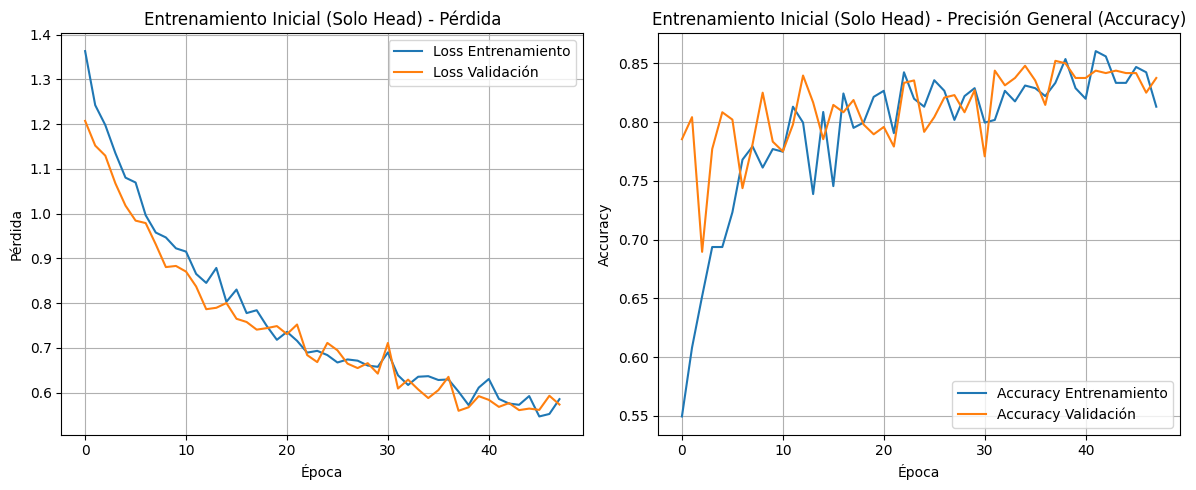

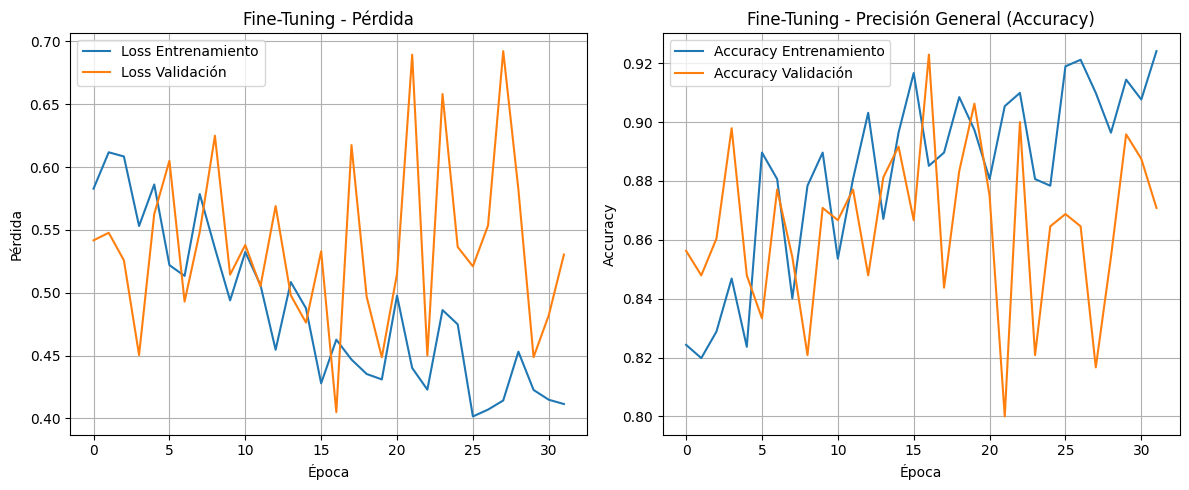

In [23]:
# --- 7. Visualización del Historial de Entrenamiento ---
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss Entrenamiento')
    plt.plot(history.history['val_loss'], label='Loss Validación')
    plt.title(f'{title} - Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Accuracy Validación')
    plt.title(f'{title} - Precisión General (Accuracy)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Visualizando el Historial de Entrenamiento ---")
plot_history(history_initial, 'Entrenamiento Inicial (Solo Head)')
plot_history(history_fine_tuning, 'Fine-Tuning')

In [24]:
model.save('modelo_neumonia_transfer_learning.N2')
print("Modelo guardado exitosamente.")

INFO:tensorflow:Assets written to: modelo_neumonia_transfer_learning.N2/assets


INFO:tensorflow:Assets written to: modelo_neumonia_transfer_learning.N2/assets


Modelo guardado exitosamente.


In [ ]:
#### Predicción con imágenes

Found 468 images belonging to 2 classes.
Modelo 'modelo_neumonia_transfer_learning.h5' cargado exitosamente.
Obteniendo predicciones del conjunto de prueba...
468/468 [==============================] - 487s 1s/step

--- Resumen de Resultados ---
Total de imágenes en test: 468
Correctos Positivos (Neumonía correctamente predicha): 131
Correctos Negativos (Normal correctamente predicho): 228
Falsos Positivos (Normal predicho como Neumonía): 6
Falsos Negativos (Neumonía predicha como Normal): 103
Accuracy Calculado: 76.71%

--- Visualizando Predicciones Correctas ---


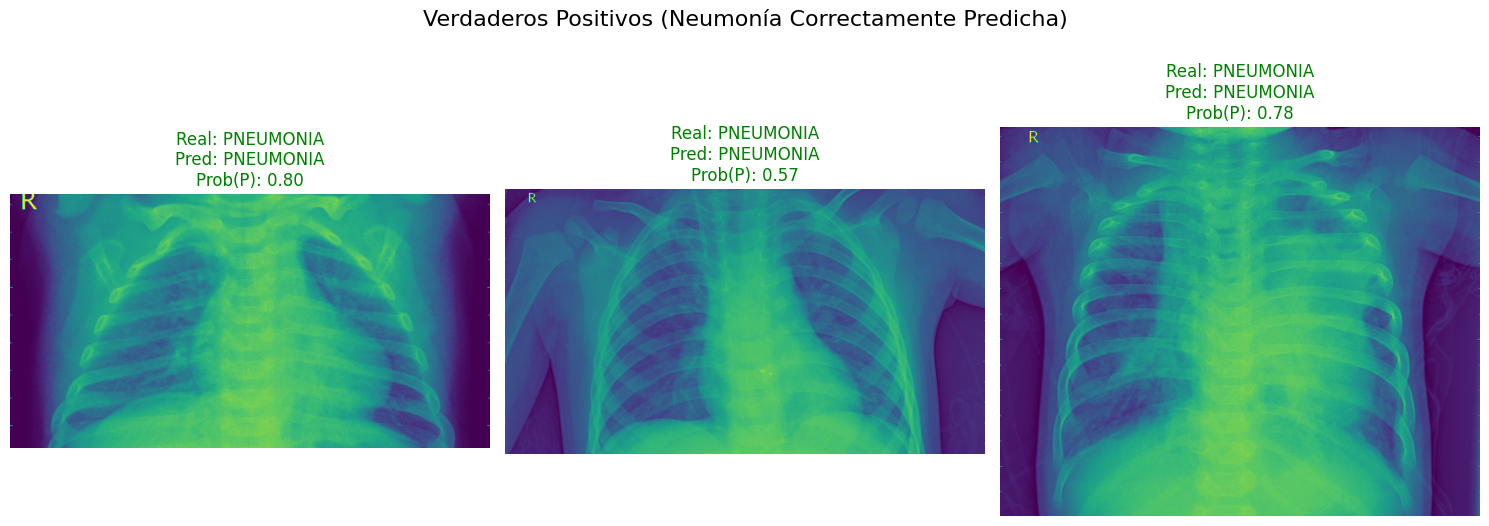

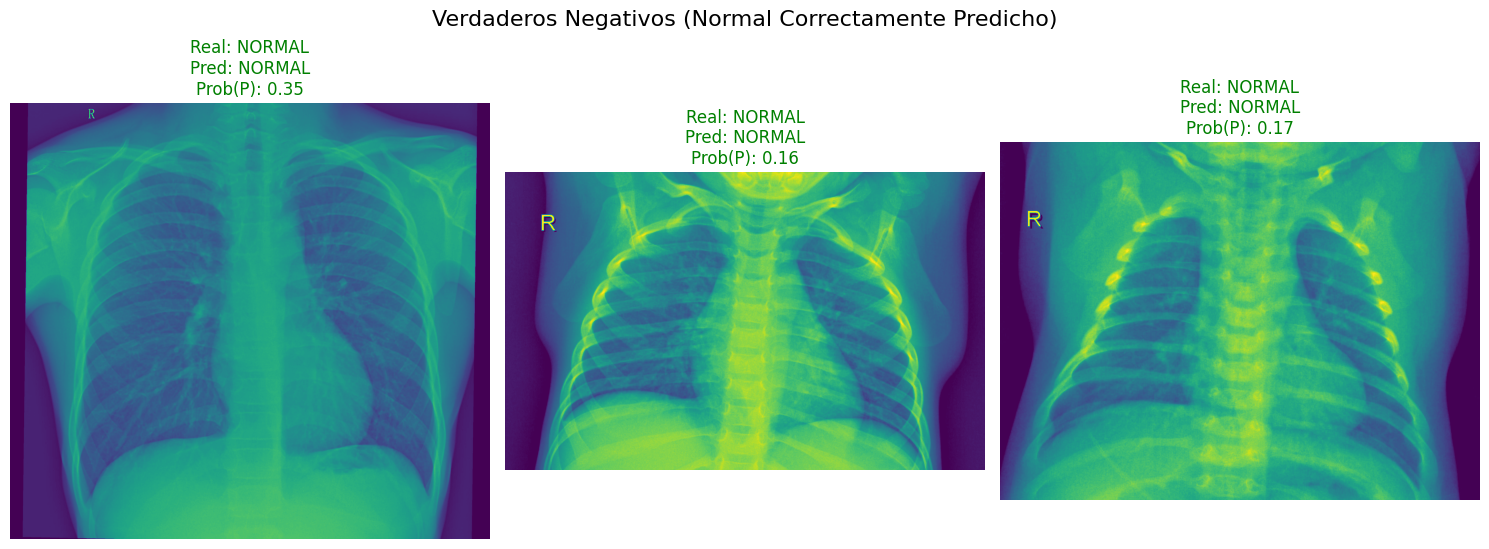


--- Visualizando Errores (para entender qué falló) ---


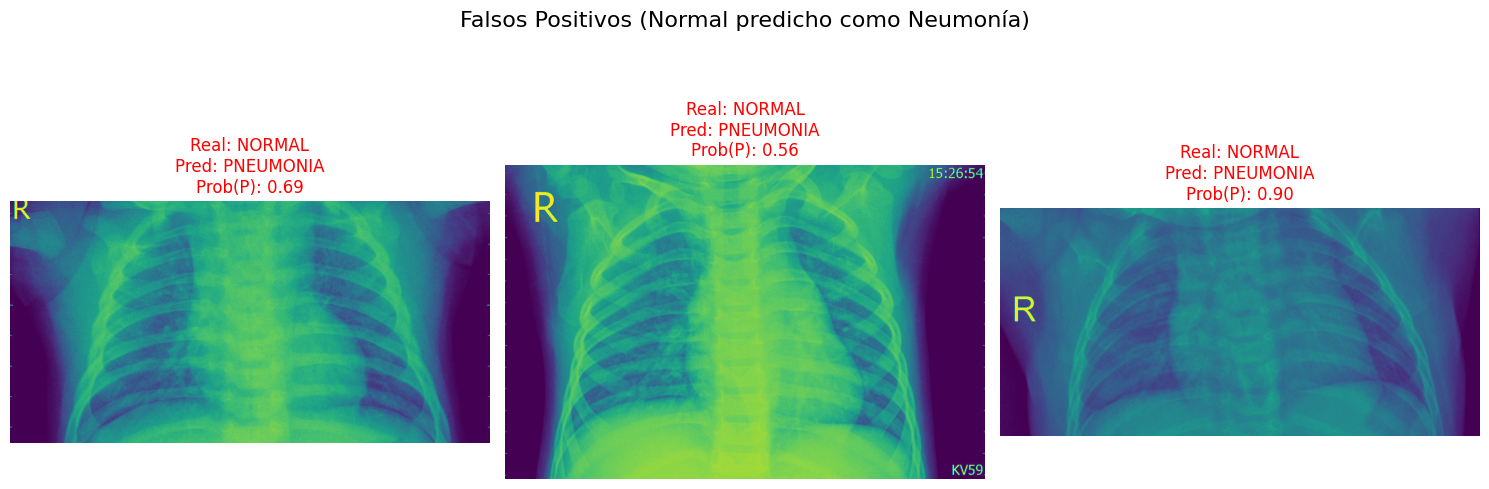

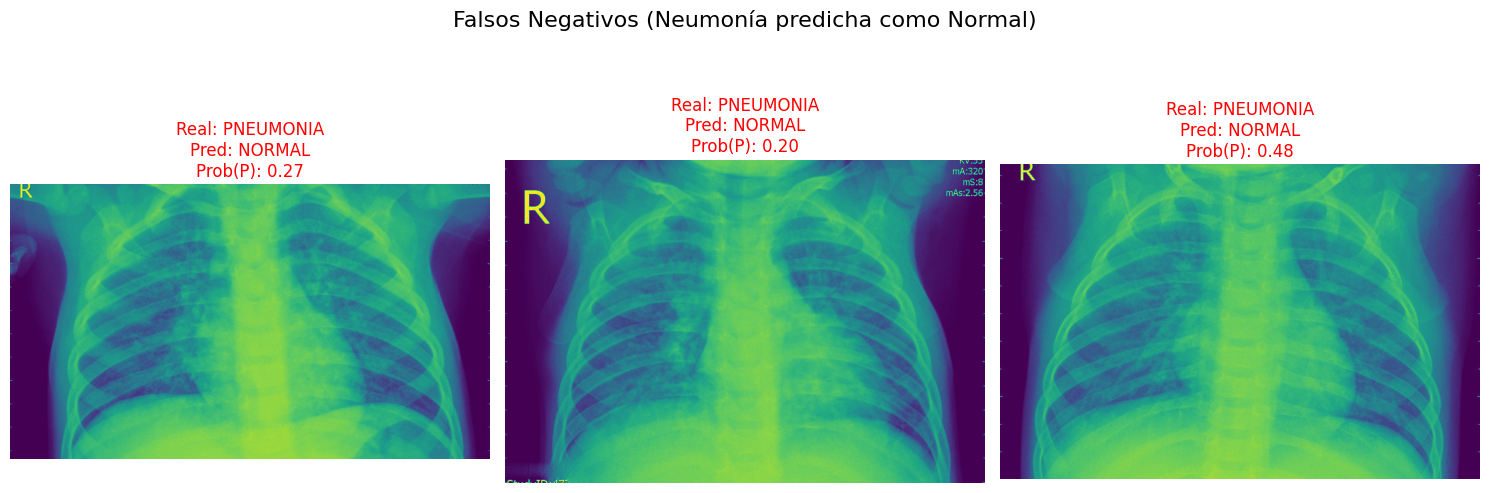


Análisis visual de predicciones completado.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.models import load_model # 
# --- Configuración del Generador de Prueba y Carga del Modelo ---
# Define las rutas de datos para el test_generator (asegúrate de que sean correctas)
img_width, img_height = 150, 150
test_dir = '/home/variante/ProyectosPython/PROYECTONEU2/DATOS235/test/'

# Usamos el mismo ImageDataGenerator para el test set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
val_test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1, # Es crucial tener batch_size=1 para predecir imagen por imagen
    class_mode='binary',
    shuffle=False # Muy importante: NO mezclar para que las predicciones coincidan con las etiquetas reales
)

# Carga el modelo guardado
try:
    model = load_model('modelo_neumonia_transfer_learning.h5')
    print("Modelo 'modelo_neumonia_transfer_learning.h5' cargado exitosamente.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Asegúrate de que el archivo 'modelo_neumonia_transfer_learning.h5' existe en la misma carpeta.")
    exit() # Salir si no se puede cargar el modelo

# --- Obtener predicciones y etiquetas reales ---
print("Obteniendo predicciones del conjunto de prueba...")
test_generator.reset() # Resetear el generador asegura que empezamos desde el principio
predictions = model.predict(test_generator, steps=test_generator.samples, verbose=1)

# Convertir las probabilidades a clases binarias (0 o 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes

# Mapear las clases numéricas a nombres legibles
class_labels = list(test_generator.class_indices.keys())
# Para asegurar el orden si class_indices no es fijo o no es el esperado
# 'NORMAL' = 0, 'PNEUMONIA' = 1


# --- Identificar casos ---
# Correctos Positivos (TP): Real es NEUMONIA (1), Predicción es NEUMONIA (1)
tp_indices = np.where((predicted_classes == 1) & (true_classes == 1))[0]

# Correctos Negativos (TN): Real es NORMAL (0), Predicción es NORMAL (0)
tn_indices = np.where((predicted_classes == 0) & (true_classes == 0))[0]

# Falsos Positivos (FP): Real es NORMAL (0), Predicción es NEUMONIA (1)
fp_indices = np.where((predicted_classes == 1) & (true_classes == 0))[0]

# Falsos Negativos (FN): Real es NEUMONIA (1), Predicción es NORMAL (0)
fn_indices = np.where((predicted_classes == 0) & (true_classes == 1))[0]

print(f"\n--- Resumen de Resultados ---")
print(f"Total de imágenes en test: {len(true_classes)}")
print(f"Correctos Positivos (Neumonía correctamente predicha): {len(tp_indices)}")
print(f"Correctos Negativos (Normal correctamente predicho): {len(tn_indices)}")
print(f"Falsos Positivos (Normal predicho como Neumonía): {len(fp_indices)}")
print(f"Falsos Negativos (Neumonía predicha como Normal): {len(fn_indices)}")
print(f"Accuracy Calculado: { (len(tp_indices) + len(tn_indices)) / len(true_classes) * 100:.2f}%")


# --- Función para visualizar imágenes ---
def plot_samples(indices, title, num_images=3, is_error=False):
    if not indices.size:
        print(f"No hay {title} para mostrar.")
        return

    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16)

    display_indices = random.sample(list(indices), min(len(indices), num_images))

    for i, idx in enumerate(display_indices):
        plt.subplot(1, num_images, i + 1)
        image_path = test_generator.filepaths[idx]
        img = plt.imread(image_path)

        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        prob_pneumonia = predictions[idx][0] # Probabilidad de ser Neumonía

        plt.imshow(img)
        title_color = "red" if is_error else "green"
        plt.title(f"Real: {true_label}\nPred: {predicted_label}\nProb(P): {prob_pneumonia:.2f}",
                  color=title_color)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Llamar a las funciones para visualizar ---
print("\n--- Visualizando Predicciones Correctas ---")
plot_samples(tp_indices, "Verdaderos Positivos (Neumonía Correctamente Predicha)", num_images=3, is_error=False)
plot_samples(tn_indices, "Verdaderos Negativos (Normal Correctamente Predicho)", num_images=3, is_error=False)

print("\n--- Visualizando Errores (para entender qué falló) ---")
plot_samples(fp_indices, "Falsos Positivos (Normal predicho como Neumonía)", num_images=3, is_error=True)
plot_samples(fn_indices, "Falsos Negativos (Neumonía predicha como Normal)", num_images=3, is_error=True)

print("\nAnálisis visual de predicciones completado.")